### Desafío - Inferencia de tópicos con EM
#### CAMILA VERA VILLA
#### septiembre 04

### Descripción

* En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta dump.
* Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
* En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción.
* Para ello implementaremos un modelo conocido como Latent Dirichlet Allocation que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

### Ejercicio 1: Preparar el ambiente de trabajo
* Importe los módulos numpy , pandas , matplotlib , seaborn , glob y os siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta dump .
* Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente genere un objeto pd.DataFrame que contenga todos los csv. 
* Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [1]:
# librerias clasicas
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

#libreria sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

#importe de archivos y ejecucion de comandos de consola
import glob,os

# librerias para graficar
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
from wordcloud import WordCloud

In [13]:
file_list = glob.glob(os.getcwd() + '/dump/*.csv') # Recuperar la lista con todos los .csv en la carpeta dump
append_csv = [] # Arreglo de pd.Dataframes

for f in file_list:
    append_csv.append(pd.read_csv(f).drop(columns = 'Unnamed: 0'))
df_lyrics = pd.concat(append_csv) # Concatenamos todos los datafrrames en uno solo
df_lyrics.columns = ['Artist', 'Genre', 'Song', 'Lyrics'] # Renombramos las columnas del nuevo dataframe

In [14]:
df_lyrics.head()

,Artist,Genre,Song,Lyrics
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee..."
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...


In [15]:
df_lyrics.shape

(9489, 4)

### Ejercicio 2: Matriz de ocurrencias
* Importe la clase CountVectorizer dentro de los módulos feature_extraction.text de la librería sklearn.
* Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.
* Con la clase inicializada, incorpore las letras con el método fit_transform y guarde los resultados en un nuevo objeto

In [16]:
count_vectorizer=CountVectorizer(stop_words='english', max_df = .1, max_features = 5000)
transformed_feats = count_vectorizer.fit_transform(df_lyrics['Lyrics'])

### Ejercicio 3: Entrenamiento del Modelo
* Importe sklearn.decomposition.LatentDirichletAllocation y sklearn.model_selection.GridSearchCV .
* Genere una búsqueda de grilla con los siguientes hiperparámetros:
    * n_components: [5, 10, 15] .
    * learning_decay: [0.7, 0.5] .
* Entrene la búsqueda de grilla con las letras en un formato vectorizado con CountVectorizer .
* Reporte brevemente cuál es la mejor combinación de hiperparámetros.

In [21]:
#busqueda de grilla 
search_params = {'n_components': [5,10,15], 'learning_decay':[0.7, 0.5]} #learningg_decay, afecta el learning grade para que se haga mas pequeno con el tiempo
#por defecto GridSearchCV implementa 3 validaciones. 18 modelos a estimar
model_cv_lda = GridSearchCV(LatentDirichletAllocation(learning_method = 'online'), param_grid= search_params, n_jobs=-1, cv = 5).fit(transformed_feats)

In [23]:
mejor_lda = model_cv_lda.best_estimator_

model_cv_lda.best_params_

{'learning_decay': 0.7, 'n_components': 5}

In [19]:
model_cv_lda.best_score_

-1324263.043983086

In [28]:
#importar el mejor modelo guardado anteriormente
from joblib import dump, load
#dump(cv_lda_model.best_estimator_, 'Latentd_dirichlet_alloc.joblib')
best_lda= load('Latent_dirichlet_alloc.joblib')

C:\Users\camve\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.20.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [29]:
mejor_lda.get_params

<bound method BaseEstimator.get_params of LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)>

### Ejercicio 4 : Inferencia e Identificación de Tópicos
* En base a la mejor combinación de hiperparámetros, entrene el modelo con la matriz de atributos de las letras.
* Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15 palabras asociadas con éste. 
* Puede implementar la siguiente línea de código para identificar las principales palabras en un tópico:

```python
# mediante .components_ podemos extraer una matriz que entrega las
distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(fit_best_lda.components_):
# para cada tópico
print("tópico: {}".format(topic_id + 1))
# mediante argsort logramos ordenar los elementos por magnitud
# para los elementos más relevantes ordenados por argsort, buscamos su
correlativo
# en la matriz dispersa y devolvemos el nombre.
# finalmente concatenamos las palabras
print(" ".join([counter.get_feature_names()[i] for i in
topic_name.argsort()[:-15 - 1: -1]]))

```

* Comente a qué tópicos está asociada cada clase inferida.

In [31]:
best_lda.components_

array([[  0.20119579,  16.37531942,   9.69735454, ...,   0.24979635,
          0.25385837,  34.97640742],
       [  7.63349855, 135.88728271,  52.49329486, ...,  54.65807535,
         19.79331817,   4.88872689],
       [ 26.83146588,   0.20435417,   0.22690439, ...,   0.21038416,
         10.77359354,   0.20685857],
       [  0.20525421,   0.20257775,   0.20408506, ...,   0.20768681,
          0.20051452,   0.20093895],
       [  5.99727706,   0.20252094,   3.14857709, ...,   0.20471205,
          0.20474654,   0.20182029]])

In [32]:
count_vectorizer.get_feature_names()[500]

'bred'

In [33]:
#modelo mejorado guia
for topic_id, topic_name in enumerate(best_lda.components_):
        print('topico: {}'.format(topic_id + 1))
        print(' '.join([count_vectorizer.get_feature_names()[i] for 
                        i in topic_name.argsort()[:-15-1:-1]]))

topico: 1
rock roll uh beat mos def everybody yes hands whoa party ready jump ha mon
topico: 2
niggas niggaz ma fuckin gon rap bitches game da uh dre bout wit verse eminem
topico: 3
didn talk friends everybody wrong dance mama maybe work somebody going crazy took friend went
topico: 4
ooh ah la tonight ba na believe moment boom body bring yes future babe save
topico: 5
sun pain fall hell sky dream forever coming lost rain kill war cold free dark


In [34]:
#modelo propio

model_cv_lda.best_estimator_.components_

array([[ 32.56787947,  12.95134743,  51.84231401, ...,  17.1968467 ,
          0.30854167,   0.20822471],
       [  5.97658534,   0.20413923,   0.21344354, ...,   0.20298314,
          0.20828992,   0.2016253 ],
       [  0.20512778, 127.97322196,  27.48138987, ...,  30.60084326,
         34.14689859,  32.73028668],
       [  0.20231182,   0.2017664 ,   0.2086153 , ...,   0.20633215,
          0.2006185 ,   0.2022122 ],
       [  0.33280589,   0.20298092,   0.28623089, ...,   0.20290865,
          0.20162034,   0.20191813]])

In [35]:
#modelo propio

model_cv_lda.best_estimator_.components_

for topic_id, topic_name in enumerate(model_cv_lda.best_estimator_.components_):
        print('topico: {}'.format(topic_id + 1))
        print(' '.join([count_vectorizer.get_feature_names()[i] for 
                        i in topic_name.argsort()[:-15-1:-1]]))

topico: 1
whoa tonight work girls getting ha car fly best eat going dirty body room hot
topico: 2
hell pain war lord rock fight power kill save burn alive roll free living earth
topico: 3
niggas uh niggaz rock ma rap fuckin gon bitches wit game da check huh word
topico: 4
ooh ah la everybody yes dance mama friends care wrong moment didn maybe talk somebody
topico: 5
sun na dream sky believe waiting fall forever rain dreams dark comes open true far


In [36]:
df_lyrics.columns

Index(['Artist', 'Genre', 'Song', 'Lyrics'], dtype='object')

(-0.5, 1599.5, 1199.5, -0.5)

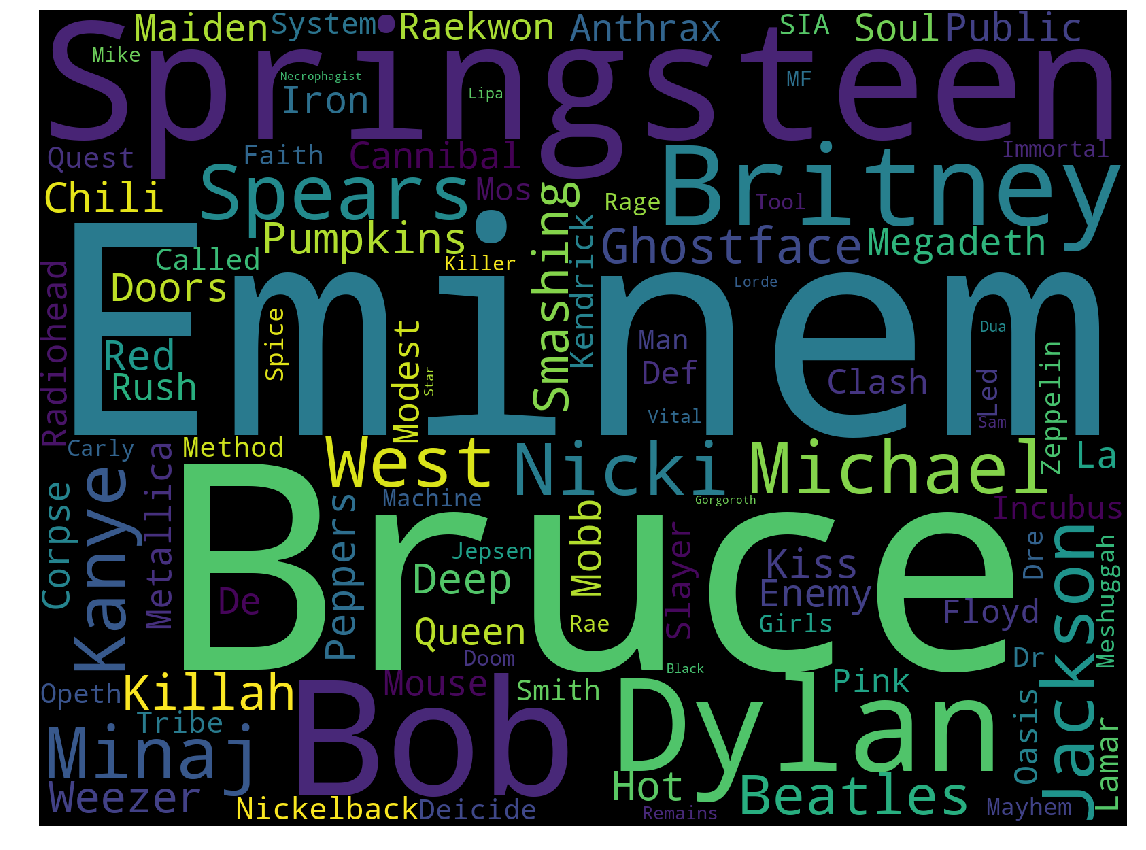

### Ejercicio 5: Identificación de probabilidades
* En base a la información generada, es posible identificar cuales van a ser los géneros más probables de ocurrir para un artista. 
* Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de datos original. Podemos implementar esto de la siguiente manera:
```python
# generamos una transformación de los datos a distribución de tópico por
palabra en el documento
fit_best_lda = best_lda.transform(transformed_feats)
# estra transformación la podemos coercionar a un dataframe de la siguiente
manera
topics_for_each_doc = pd.DataFrame(
# pasamos esta matriz y la redondeamos en 3 decimales
np.round(fit_best_lda, 3),
# agregamos un índice
index=df_lyrics.index
)
#agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1,
best_lda.n_components + 1)))
# concatenamos las probabilidades de tópico por documento a nuestra matriz
original
concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(docs_topics.values, axis=1) + 1
```

* Genere una matriz de correlaciones entre la probabilidad de tópicos inferidos. Comente brevemente cuales son las principales asociaciones existentes.
* Con esta nueva base de datos, identifique las probabilidades de pertenencia para un artista específico.
* Grafique la distribución de las probabilidades para algún artista en específico.

In [38]:
fit_best_lda = best_lda.transform(transformed_feats)
#df
topics_for_each_doc = pd.DataFrame(np.round(fit_best_lda, 3),index=df_lyrics.index)

topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1,best_lda.n_components + 1)))
concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [39]:
topics_for_each_doc.head()

,T: 1,T: 2,T: 3,T: 4,T: 5
0,0.008,0.008,0.007,0.088,0.889
1,0.321,0.006,0.006,0.006,0.660
2,0.004,0.004,0.751,0.004,0.238
3,0.443,0.004,0.004,0.004,0.544
4,0.004,0.004,0.004,0.098,0.889


In [40]:
# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df_lyrics, topics_for_each_doc], axis=1)
# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1

In [41]:
concatenated_df.head()

,Artist,Genre,Song,Lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
0,Anthrax,metal,Deathrider,"Riding hard, high in the saddle \n Winged stee...",0.008,0.008,0.007,0.088,0.889,5
1,Anthrax,metal,Metal Thrashing Mad,Racing down the road \n In a street machine of...,0.321,0.006,0.006,0.006,0.660,5
2,Anthrax,metal,I'm Eighteen,Lines form on my face and hands \n Lines form ...,0.004,0.004,0.751,0.004,0.238,3
3,Anthrax,metal,Panic,Move it to the front \n Reaching for the light...,0.443,0.004,0.004,0.004,0.544,5
4,Anthrax,metal,Subjugator,Out in the streets \n We're fighting tonight \...,0.004,0.004,0.004,0.098,0.889,5


In [42]:
concatenated_df.sample(10)

,Artist,Genre,Song,Lyrics,T: 1,T: 2,T: 3,T: 4,T: 5,highest_topic
46,System of a Down,rock,Soldier Side (Intro),"Welcome, to the soldier side \n Where there's ...",0.050,0.050,0.050,0.050,0.798,5
135,Rush,rock,Out Of The Cradle,It's not a place \n It's a yearning \n It's no...,0.190,0.004,0.004,0.004,0.797,5
73,Spice Girls,pop,Merry Christmas Everybody,Are you hangin' up a stocking on your wall? \n...,0.029,0.003,0.608,0.174,0.186,3
114,Kendrick Lamar,hiphop,Give It 2 U,"Yeah, huh \n Yeah, baby baby \n Yeah, baby bab...",0.229,0.376,0.178,0.157,0.060,2
5,Mobb Deep,hiphop,Hold Down The Fort,"Yeah, we gotta hold down the fort \n We gotta ...",0.094,0.895,0.001,0.001,0.010,2
0,Megadeth,metal,Last Rites/Loved To Death,Your body's empty now \n As I hold you \n Now ...,0.107,0.007,0.208,0.007,0.670,5
63,The Beatles,rock,It's Only Love,"I get high when I see you go by \n My, oh my \...",0.013,0.013,0.013,0.663,0.299,4
0,Kendrick Lamar,hiphop,Is It Love,(Angela McCluskey (Kendrick Lamar)) \n Sit sti...,0.033,0.559,0.001,0.001,0.405,2
79,System of a Down,rock,Deserate,Let me desecrate you child \n Let me penetrate...,0.004,0.004,0.004,0.499,0.489,4
28,Killer Mike,hiphop,JoJo's Chillin,(Intro: Killer Mike) \n This album was created...,0.001,0.512,0.368,0.001,0.118,2


***Matriz de correlaciones entre la probabilidad de tópicos inferidos***

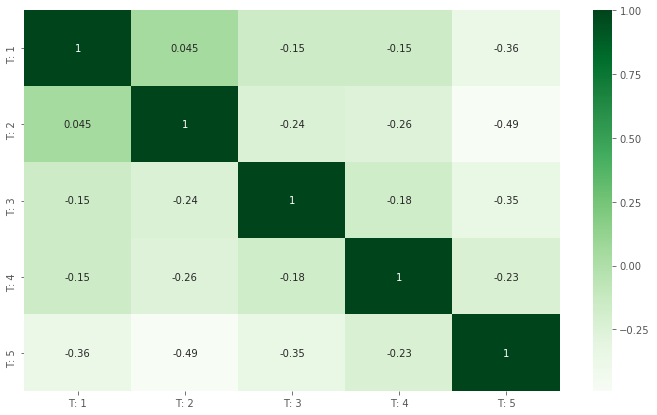

In [43]:
plt.rcParams['figure.figsize'] = (12,7)
sns.heatmap(concatenated_df.loc[:, 'T: 1':'T: 5'].corr(), annot=True, cmap='Greens');

In [46]:
df_lyrics['Artist'].value_counts()

Eminem                      493
Bruce Springsteen           467
Bob Dylan                   447
Britney Spears              323
Nicki Minaj                 282
Michael Jackson             279
Kanye West                  273
The Beatles                 265
Ghostface Killah            255
The Smashing Pumpkins       254
Weezer                      251
Mobb Deep                   231
Red Hot Chili Peppers       226
Kiss                        219
The Doors                   214
Public Enemy                198
Megadeth                    190
Queen                       188
Iron Maiden                 185
Raekwon                     184
De La Soul                  174
Cannibal Corpse             171
Anthrax                     170
Rush                        167
Metallica                   155
Modest Mouse                154
Radiohead                   151
Slayer                      147
The Clash                   145
Pink Floyd                  135
                           ... 
Kendrick

(-0.5, 1599.5, 1199.5, -0.5)

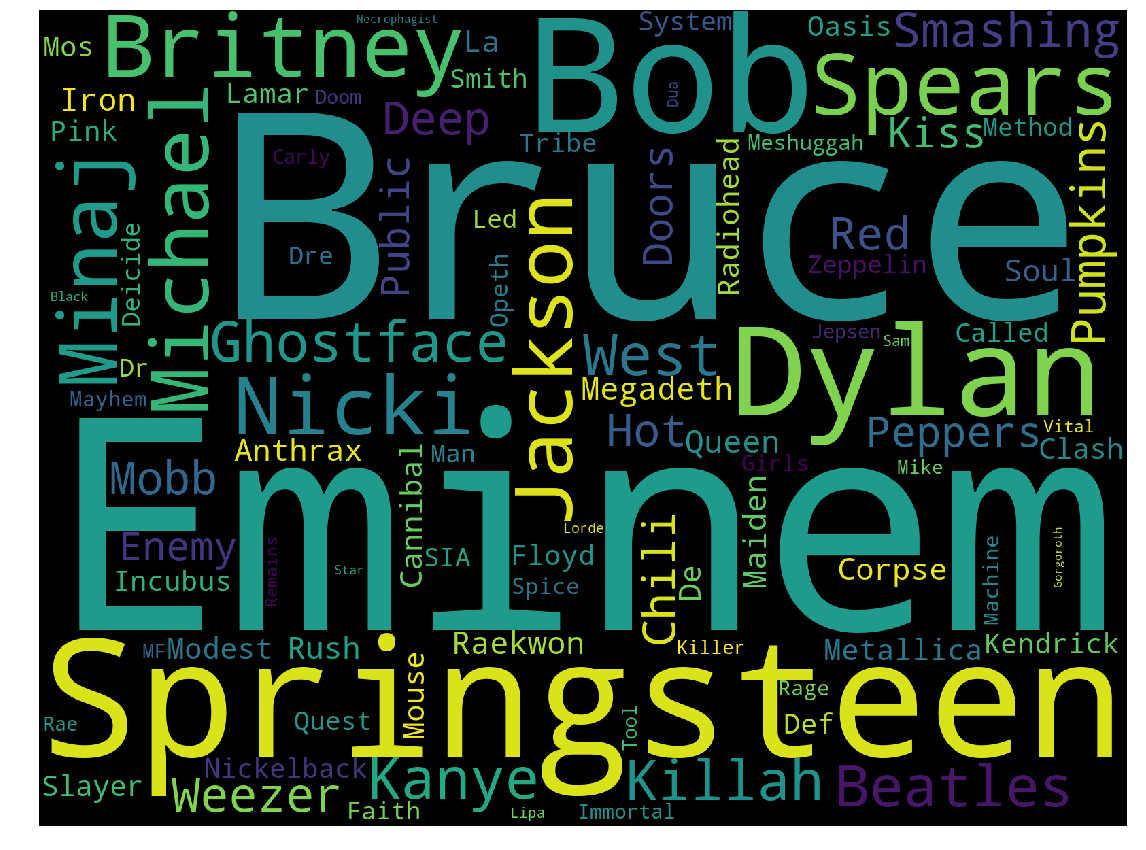

In [47]:
#wordcloud de artistas
cloud = WordCloud(width=1600, height=1200, collocations=False).generate(" ".join(df_lyrics['Artist'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

***Probabilidades de pertenencia para un artista específico: Pink Floyd***

In [54]:
def fetch_mixture(df, artist):
    return df[df['Artist'] == artist].loc[:, 'T: 1':'T: 5']

mos_def = fetch_mixture(concatenated_df, 'Pink Floyd')
mos_def.columns = ['hardcore-rap', 'rock', 'pop', 'metal','bling-era']
mos_def.apply(np.mean,axis = 0).sort_values()

rock            0.062267
hardcore-rap    0.069370
metal           0.074578
pop             0.241659
bling-era       0.552148
dtype: float64

***Boxplot de la carga de hardcore-rap, rock, pop, metal, bling-era para Pink Floyd***

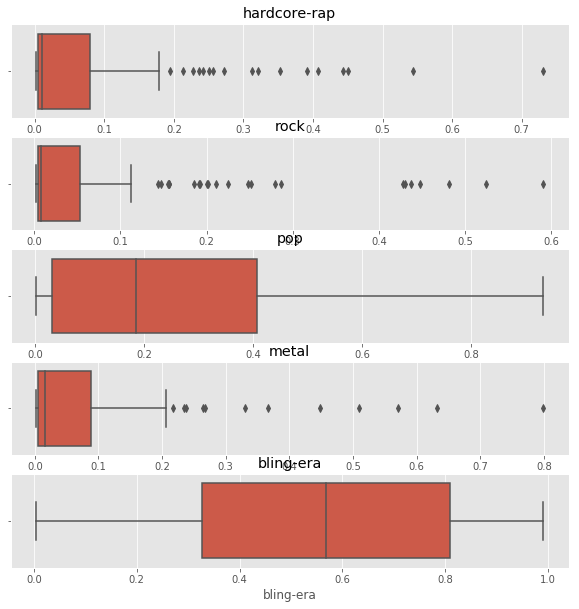

In [60]:
plt.figure(figsize=(10, 10))
for index, (colname, serie) in enumerate(mos_def.iteritems()):
    plt.subplot(5, 1, index + 1)
    sns.boxplot(serie, orient='h')
    plt.title(colname)